<a href="https://colab.research.google.com/github/hollyemblem/raschka-llm-from-scratch/blob/main/chapter_3_attention_mechanisms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 3: Attention Mechanisms



#### Challenges with modelling long sequences

Imagine we are implementing a language translation model. We can't simply translate text word by word, due to differing grammatical structures between source and target.

To historically get around this, we use a deep NN with encoder/decoder structures, to read in the entire text (encoder's job) and then produce translated text (decoder's job).

Prior to transformers, RNNs were the dominant choice for this. For encoder-decoder RNNs; encoder updates its hidden state (values at each hidden layer) to try and obtain meaning of entire sentence in final hidden state. Decoder then takes this final hidden state to generate a translated sentence. Decoder also updates it's hidden state per step, to have context necessary for next-word prediction.

Key idea: Encoder processes entire input text into a hidden state (memory cell), the decoder then takes this to produce the output. Has one single state in encoder before passing to decoder.

Challenge: RNNs can't access earlier hidden states from the encoder during decoding. Decoder relies on current hidden state - this leads to loss of context, esp. in complex sentences.

#### Moving onto attention mechanisms

Researchers develop the Badhdanau attention mechanism for RNNs, so decoder can selectively access different parts of input sequence at each decoding step.

Model has access to all input tokens and some are more important than others for generating an output token; this is determined via attention weights.

In 2017, transformer architecture was then proposed.



### Self-Attention Mechanism

Definition: Allows each position in input sequence to consider relevancy (or attend to) all other positions in same sequence when computing representation of a sequence.

Why is it _self_ attention? Assesses and learns the relationships and dependencies between various parts of input itself - like words in a sentence. This differs from examples like seq2seq model (RNNs), where attention might be between an input and output sequence


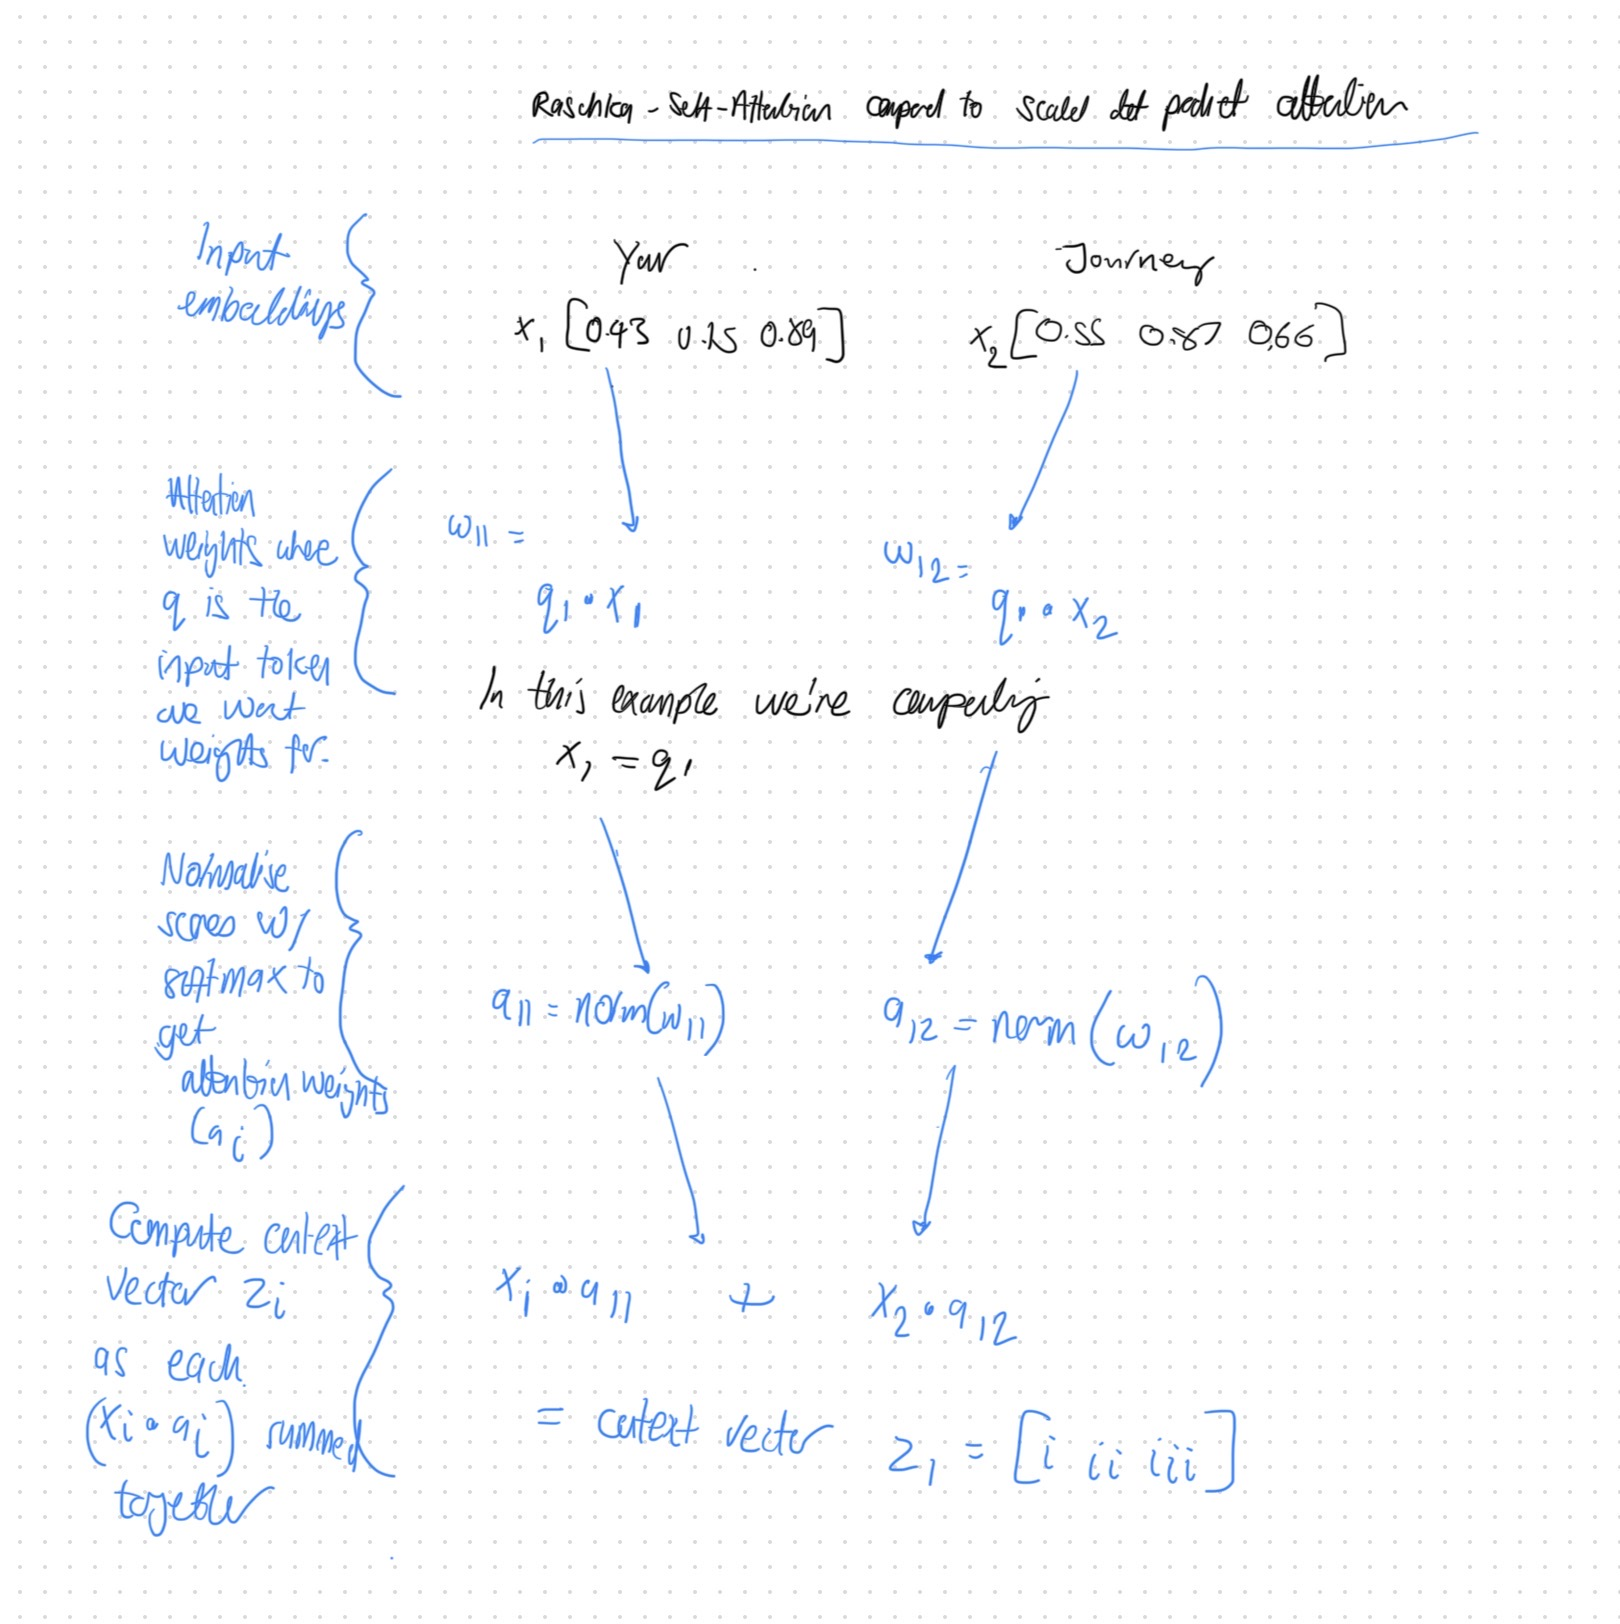

### Extended Diagram
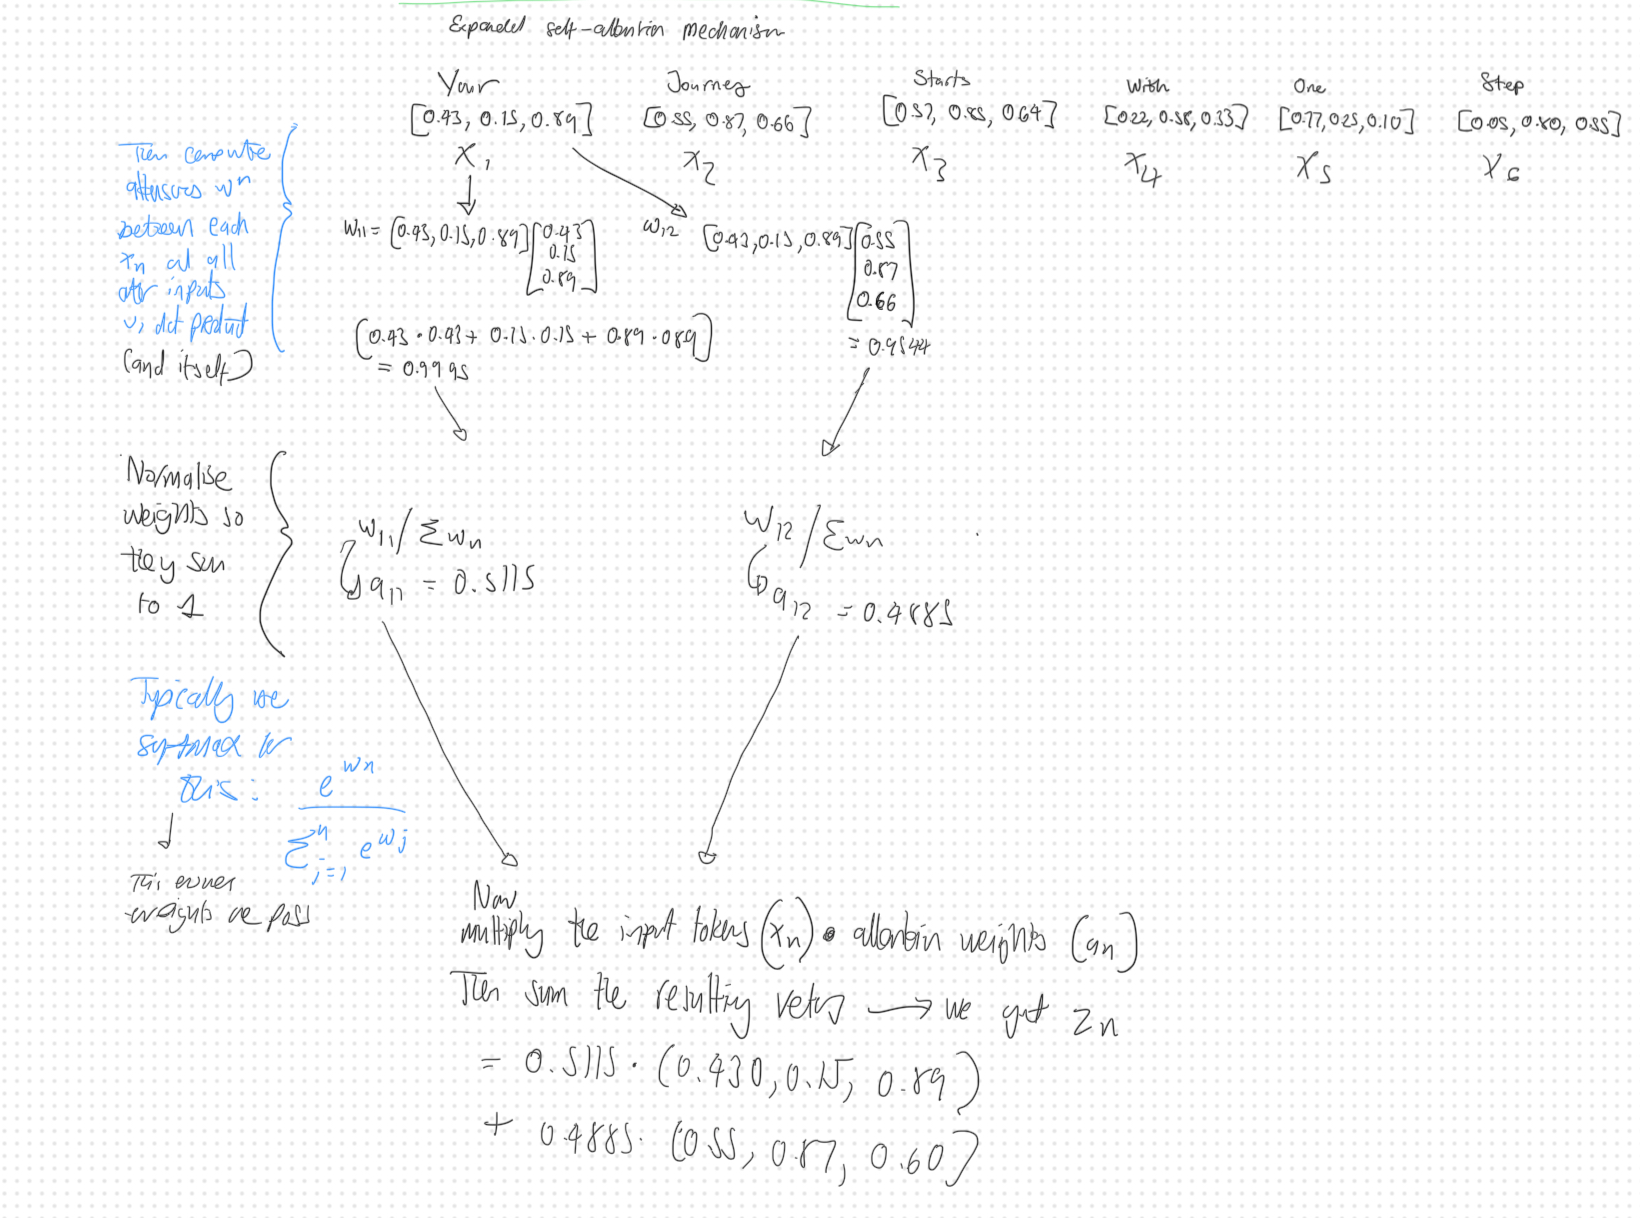

Importance in relation to dot product:
"In the context of self-attention mechanisms, the dot product determines the extent to which each element in a sequence focuses on, or “attends to,” any other element: the higher the dot product, the higher the similarity and attention score between two elements."

In [2]:
### Coding attention mechanisms - creating the intermediary attention scores

In [4]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [5]:
query = inputs[0]                            #1
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310])


In [6]:
##Basic normalisation

In [7]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

In [8]:
attn_weights_2_tmp

tensor([0.2241, 0.2140, 0.2113, 0.1066, 0.1026, 0.1415])

In [9]:
## Creating context vectors

In [10]:
query = inputs[0]         #1
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2_tmp[i]*x_i
print(context_vec_2)

tensor([0.4440, 0.6000, 0.5991])


In [11]:
##Tiny example

In [12]:
tiny_input = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
  ]
)

In [13]:
query = inputs[0]                            #1
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)

tensor([0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310])


In [14]:
##Normalise

In [15]:
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()

In [16]:
attn_weights_2_tmp

tensor([0.2241, 0.2140, 0.2113, 0.1066, 0.1026, 0.1415])

In [17]:
query = tiny_input[0]         #1
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(tiny_input):
    context_vec_2 += attn_weights_2_tmp[i]*x_i
print(context_vec_2)

tensor([0.2141, 0.2198, 0.3407])


In [18]:
##Manual calculations
'''
In this example we compute manually the input vectors * the attention weight scores, to obtain the context vector for x1:
'''

'\nIn this example we compute manually the input vectors * the attention weight scores, to obtain the context vector for x1:\n'

In [19]:
torch.tensor([0.43, 0.15, 0.89]) * 0.223 + torch.tensor([[0.57, 0.85, 0.64]]) * 0.21 + torch.tensor( [0.57, 0.85, 0.64]) * 0.211 + torch.tensor([0.22, 0.58, 0.33]) * 0.1068 + torch.tensor([0.77, 0.25, 0.10]) * 0.102 + torch.tensor([0.05, 0.80, 0.55]) * 0.141


tensor([[0.4449, 0.5915, 0.5909]])

In [20]:
'''     Recap on matrix
             # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]

  '''

'     Recap on matrix\n             # Your     (x^1)\n   [0.55, 0.87, 0.66], # journey  (x^2)\n   [0.57, 0.85, 0.64], # starts   (x^3)\n   [0.22, 0.58, 0.33], # with     (x^4)\n   [0.77, 0.25, 0.10], # one      (x^5)\n   [0.05, 0.80, 0.55]\n\n  '

### Extending the Attention Mechanism

In the above examples we computed the context vector only in relation to the input vector x1: 'Your' - We now want to extend it to compute context vectors for all inputs.

A note on attention weights vs weight matrices used here:

-attention weights determine the extent to which a context vector depends on the different parts of the input (i.e., to what extent the network focuses on different parts of the input).

- weight parameters are the fundamental, learned coefficients that define the network's connections.

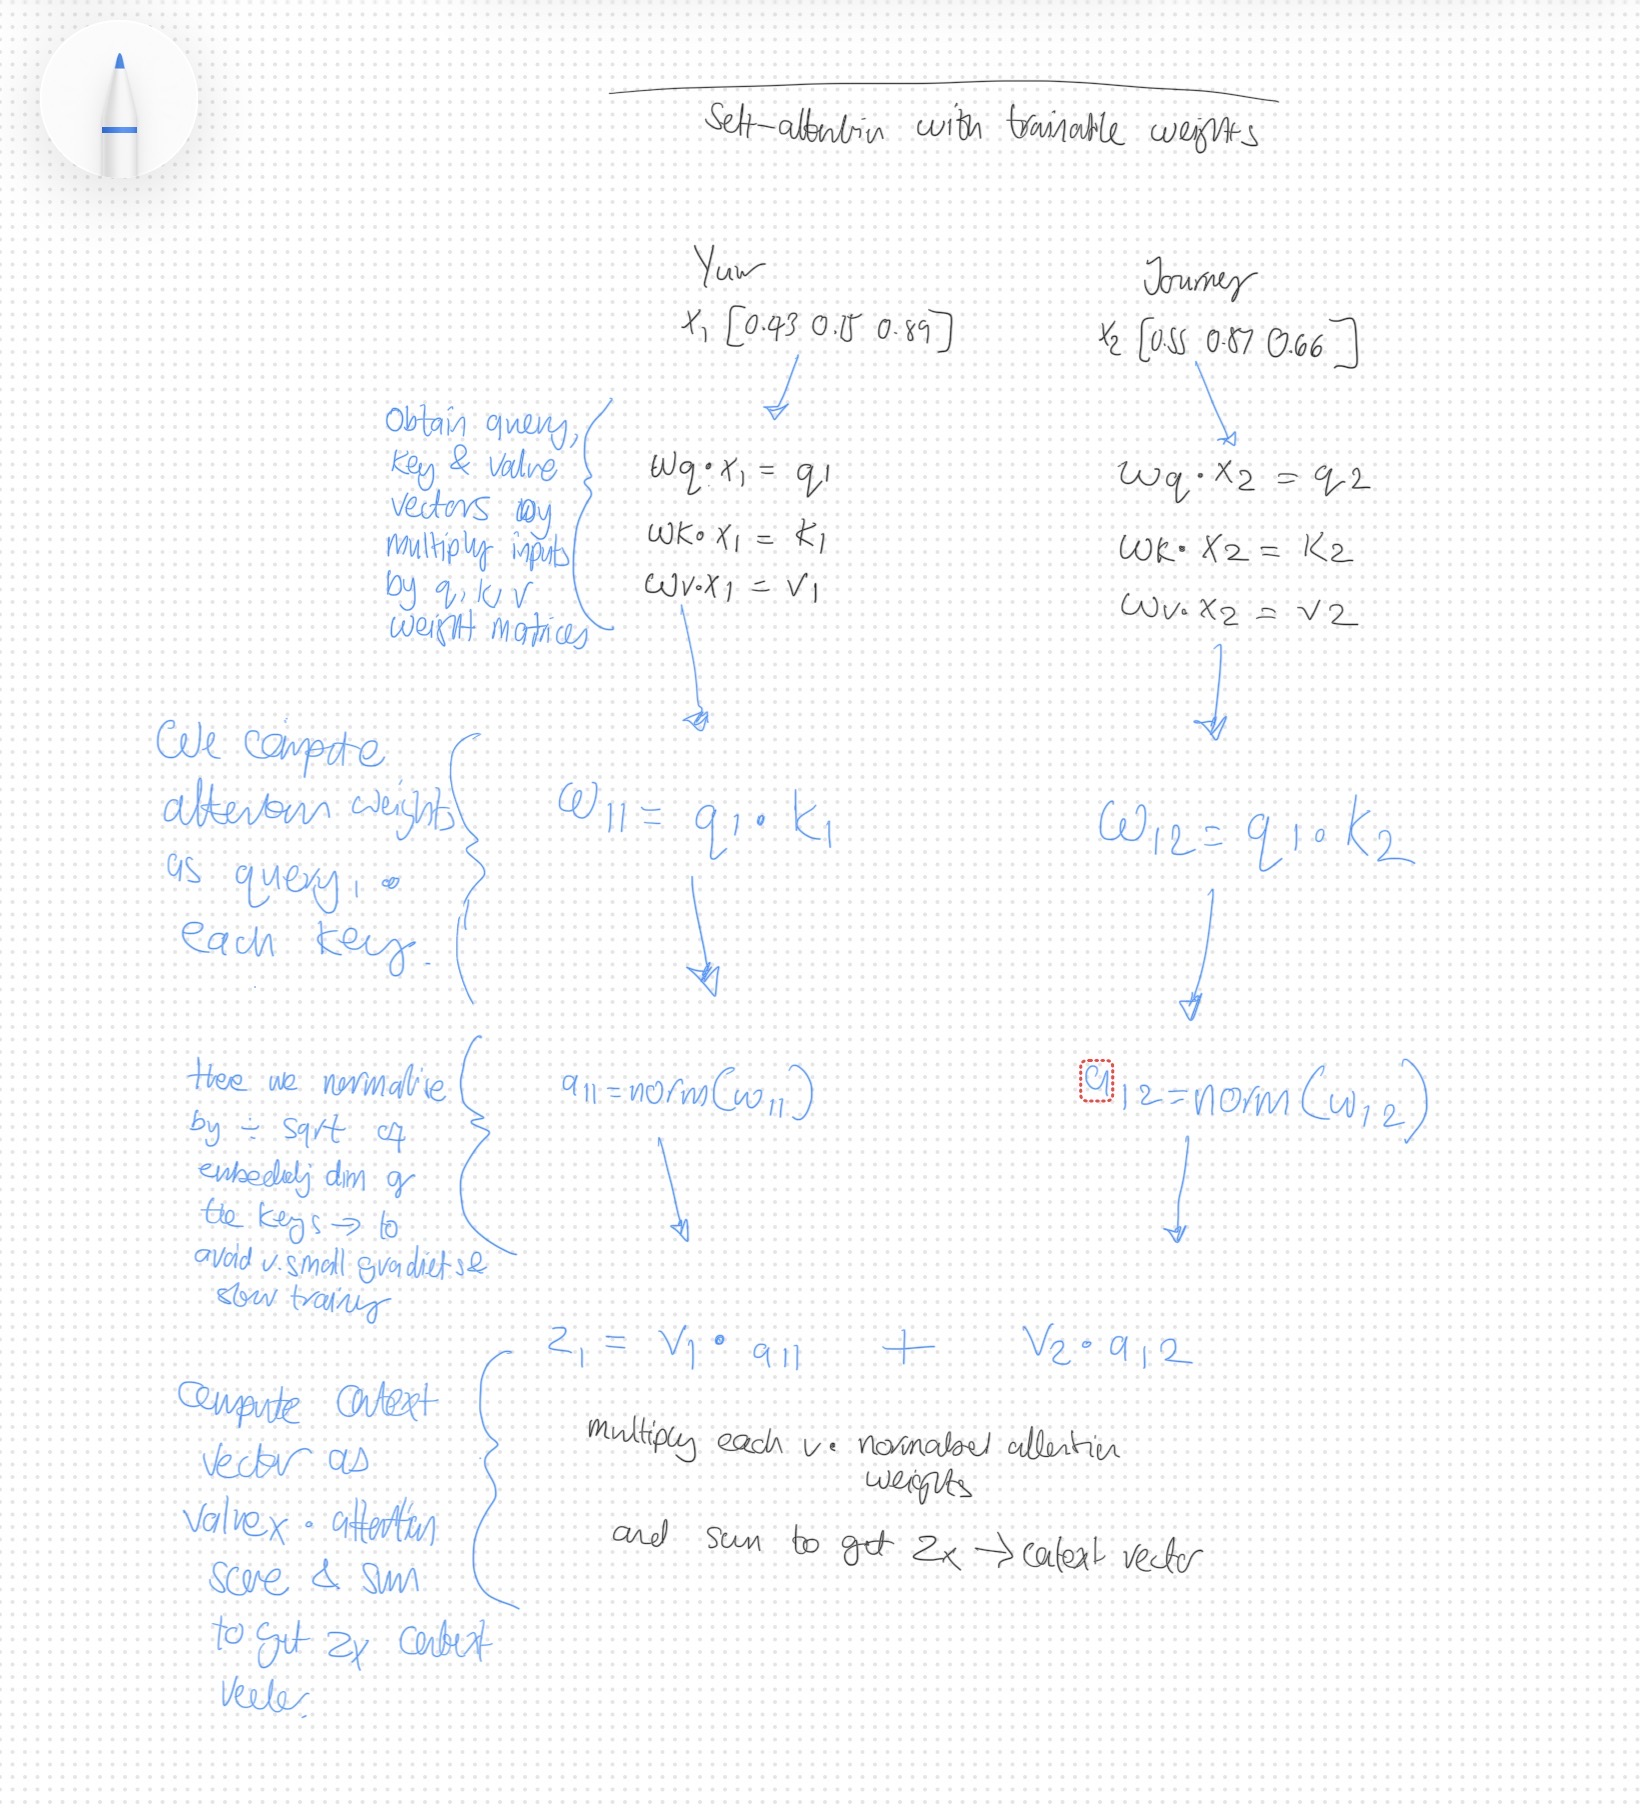

In [21]:
##First, computing attention scores (the wx):
attn_scores = torch.empty(6, 6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [22]:
##Rather than using a for loop, we can also use matrix multiplication by transposing the input matrix:

In [23]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [24]:
##Then we normalise with softmax

In [25]:
attn_weights = torch.softmax(attn_scores, dim=-1)
'''
A note on the softmax setup: By setting dim=-1, we are instructing the softmax function to apply the normalization
along the last dimension of the attn_scores tensor. If attn_scores is a two-dimensional tensor
(for example, with a shape of [rows, columns]),
it will normalize across the columns so that the values in each row (summing over the column dimension) sum up to 1.
'''
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [26]:
##Again using matmult we then create the context vectors:
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [27]:
##From our early 'tiny' example looking at your we can verify the weight here is approximate to what we manually calculated.

##  Implementing self-attention with trainable weights

We now implement scaled dot product attention. This is the self-attention mechanism used in GPT and the original transformer paper.

We are essentially adding trainable weights to attention. These are crucial so the model can learn to produce good context vectors.

In [28]:
x_1 = inputs[0]     #1
d_in = inputs.shape[1]      #2
d_out = 2         #3

In [29]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [30]:
W_query

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])

In [31]:
W_key

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])

In [32]:
W_value

Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])

In [33]:
x_1

tensor([0.4300, 0.1500, 0.8900])

In [34]:
query_1 = x_1 @ W_query
key_1 = x_1 @ W_key
value1 = x_1 @ W_value
print(query_1)

tensor([0.2309, 1.0966])


In [35]:
print(key_1)

tensor([0.3669, 0.7646])


In [36]:
x_2 = inputs[1]
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value2 = x_2 @ W_value
print(key_2)

tensor([0.4433, 1.1419])


In [37]:
##Attention scores for 'your journey'

In [38]:
w11 = query_1 @ key_1

In [39]:
w11

tensor(0.9231)

In [40]:
w12 = query_1 @ key_2

In [41]:
w12

tensor(1.3545)

In [42]:
##Normalise
w11/ (w11+w12)


tensor(0.4053)

In [43]:
w12/(w11+w12)

tensor(0.5947)

In [44]:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)


keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [45]:
attn_score_w11 = query_1.dot(key_1)
print(attn_score_w11)


tensor(0.9231)


In [46]:
attn_scores_2 = query_1 @ keys.T       #1
print(attn_scores_2)

tensor([0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330])


In [47]:
## Converting attention scores to attention weights

In [48]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1551, 0.2104, 0.2059, 0.1413, 0.1074, 0.1799])


#### A note on scaled-dot product attention

You might be wondering why we normalise the the attention weights like so:torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)

The reason is to avoid very small gradients, which can slow down training. We scale by by the square root of the embedding dimension to avoid this.

### Computing Context Vectors

"we now compute the context vector as a weighted sum over the value vectors. Here, the attention weights serve as a weighting factor that weighs the respective importance of each value vector."

In [49]:
#Similar to the earlier simplified self-attention, we multiple the attention weights by values and sum to get the context Vector.
#However, rather than xi * ai, we instead multiple the v_i computed earlier by the attention weights.

In [50]:
## Creating a tiny network from 'your journey' to review:
tiny_input = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
  ]
)

In [51]:
#Individual queries
x_1 = tiny_input[0]
query_1 = x_1 @ W_query
key_1 = x_1 @ W_key
value_1 = x_1 @ W_value

In [52]:
## First we create the weight, key, value for x1 and x2:
keys = tiny_input @ W_key
queries = tiny_input @ W_query
values = tiny_input @ W_value

attn_scores_1 = query_1 @ keys.T


In [53]:
##Then we normalise to get attention weights w/ softmax
d_k = keys.shape[-1]
attn_weights_1 = torch.softmax(attn_scores_1 / d_k**0.5, dim=-1)

In [54]:
attn_weights_1

tensor([0.4243, 0.5757])

In [55]:
##Once we've got the weights we can compute the value_xi @ normalised weights
context_vec_1 = attn_weights_1 @ values
print(context_vec_1)

tensor([0.3062, 0.9517])


In [56]:
values

tensor([[0.1855, 0.8812],
        [0.3951, 1.0037]])

In [57]:
value_1

tensor([0.1855, 0.8812])

In [58]:

context_vec_1

tensor([0.3062, 0.9517])

##  Implementing a compact self-attention Python class

In [59]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__() #initialise weight matrices
        self.W_query = nn.Parameter(torch.rand(d_in, d_out)) #transform input dimension to an output dimension
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
        # To transpose a tensor (e.g., sa_v2.W_query.weight), you can use `.T` or `.transpose(dim0, dim1)`.
        # For instance, `tensor.T` or `tensor.transpose(0, 1)` will transpose the tensor.

    def forward(self, x):
        '''
        Compute attention scores, then normalise to get attention weights.
        Compute the context vector by mat mult weights by values.
        '''
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec


In [61]:
##Using the class - we match the manual calcs above
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(tiny_input))

tensor([[0.3062, 0.9517],
        [0.3116, 0.9549]], grad_fn=<MmBackward0>)


In [64]:
#On larger dataset
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [65]:
##Improving our implementation by using linear layers

In [67]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        '''We can improve the SelfAttention_v1 implementation further by utilizing PyTorch’s nn.Linear layers,
        which effectively perform matrix multiplication when the bias units are disabled.
        Additionally, a significant advantage of using nn.Linear instead of manually implementing nn.Parameter(torch.rand(...))
        is that nn.Linear has an optimized weight initialization scheme, contributing to more stable and effective model training.
        '''
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [68]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


### Exercise 3.1 Comparing SelfAttention_v1 and SelfAttention_v2:
"Your task is to correctly assign the weights from an instance of SelfAttention_v2 to an instance of SelfAttention_v1. To do this, you need to understand the relationship between the weights in both versions. (Hint: nn.Linear stores the weight matrix in a transposed form.) After the assignment, you should observe that both instances produce the same outputs."

In [82]:
torch.transpose(sa_v2.W_query.state_dict()['weight'],0,1)

tensor([[ 0.3161, -0.1683],
        [ 0.4568, -0.3379],
        [ 0.5118, -0.0918]])

In [88]:
sa_v1.W_query.data = torch.transpose(sa_v2.W_query.state_dict()['weight'],0,1)

In [89]:
sa_v1.W_key.data = torch.transpose(sa_v2.W_key.state_dict()['weight'],0,1)

In [90]:
sa_v1.W_value.data = torch.transpose(sa_v2.W_value.state_dict()['weight'],0,1)

In [91]:
print(sa_v1(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)
